# 1. Binary Classification

### 1.1 Titanic, but correctly this time

Take your linear regression model from the workshop 3.3 on the titanic dataset.

Swap OLS for logistic regresssion and compare the classification model metrics (accuracy, ROC plot, F1, precision/recall).

How much better is logistic regression than OLS on binary data?

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

df = sns.load_dataset('titanic')
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


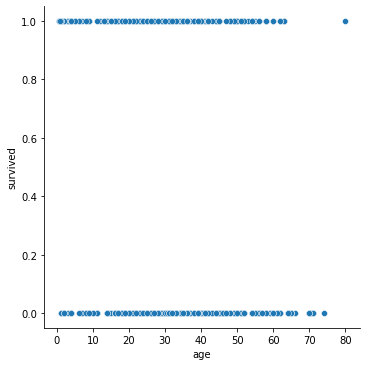

In [35]:
df = df.dropna(subset=['age'])
sns.relplot('age', 'survived', data = df)
df.head()

Optimization terminated successfully.
         Current function value: 0.672429
         Iterations 4


Text(0.5, 1.0, 'Titanic Survivors by Age')

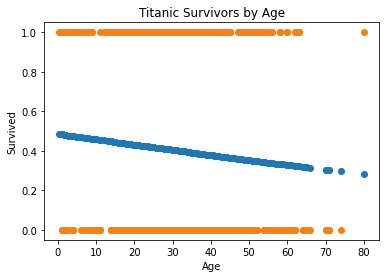

In [36]:
#Logistic Regression
log_reg = sm.Logit(df['survived'], sm.add_constant(df['age'])).fit(cov_type='HC2')
y_predict= log_reg.predict(sm.add_constant(df['age']))
plt.scatter(df['age'], y_predict)
plt.scatter(df['age'], df['survived'])
plt.xlabel('Age')
plt.ylabel('Survived')
plt.title('Titanic Survivors by Age')

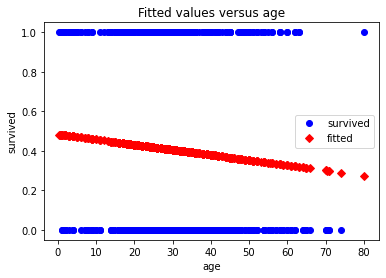

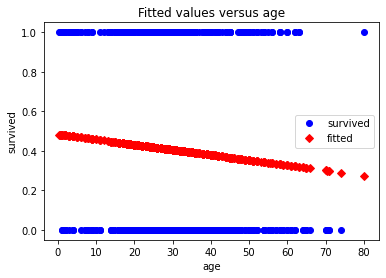

In [37]:
#OLS Regression
lin_reg = sm.OLS(df['survived'], sm.add_constant(df['age'])).fit(cov_type='HC2')
sm.graphics.plot_fit(lin_reg, 'age', vlines=False)

In [38]:
lin_reg.summary(), log_reg.summary()
#The values produced below indicate that neither the linear nor logistic regression are particularly better to assume that age was the sole factor to affect survival.

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:               survived   R-squared:                       0.006
 Model:                            OLS   Adj. R-squared:                  0.005
 Method:                 Least Squares   F-statistic:                     4.332
 Date:                Sat, 06 Feb 2021   Prob (F-statistic):             0.0377
 Time:                        15:54:20   Log-Likelihood:                -503.28
 No. Observations:                 714   AIC:                             1011.
 Df Residuals:                     712   BIC:                             1020.
 Df Model:                           1                                         
 Covariance Type:                  HC2                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ---------------------------------------------------------------------

In [39]:
from sklearn.metrics import precision_recall_fscore_support

#Logistic Regression F-Score

y_true = df['survived']
y_predict= round(log_reg.predict(sm.add_constant(df['age'])))

precision_recall_fscore_support(y_true, y_predict)

(array([0.59383754, 0.        ]),
 array([1., 0.]),
 array([0.74516696, 0.        ]),
 array([424, 290]))

In [40]:
#Linear Regression F-score
df['y_predict_p'] = lin_reg.predict(sm.add_constant(df['age']))
df['y_predict2'] = y_predict.apply(lambda x: 0 if x < 0.5 else 1)

precision_recall_fscore_support(y_true, df['y_predict2'])

(array([0.59383754, 0.        ]),
 array([1., 0.]),
 array([0.74516696, 0.        ]),
 array([424, 290]))

In [41]:
#Both the logistic and linear regressions give the same values for precision, recall, and F-score. Therefore, the data is not significantly different between the two methods, which further reinforces our summary data above.

# 2. Intro To Computer Vision

The [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) is a classic in computer vision. It's a database of manually written digits (from 0 to 9) scanned into a 28x28 pixel image.

The `X` matrix is 784 numbers (28x28) with numbers saying how dark the pixel is. The `y` variable is the number. The task is to use the images to do optical recognition.

You can fetch the dataset with the following command:

```
from sklearn.datasets import fetch_openml
fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
```

Use sklearn's logistic regression and any of the tricks you want to boost predictive accuracy. Here's a few notes:

- Use the sklearn `train_test_split` we saw in class to keep some holdout data to test on.

- You can use whatever sklearn preprocessing you think is relevant. Here's a few: 
```
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
```

- Since there's many features (especially if you use data augmentation like polynomial features), this is a good time to use regularization. Try to find the best regularization parameters possible.

- You should be able to get at least 80% on a test set size of 10_000

In [42]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

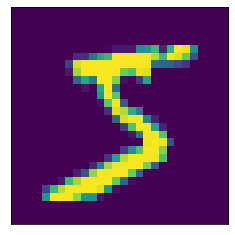

In [43]:
import matplotlib.pyplot as plt

ax = plt.axes(xticks=[], yticks=[])
ax.imshow(X[0].reshape((28, 28)))#reshape X into 28 x 28 for plotting

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.143, random_state=42) #0.143 is 1/7 (want 10000 datapoints instead of 70000)

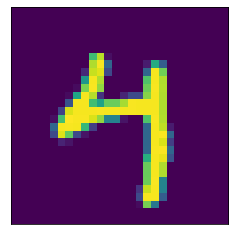

In [45]:
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(X_train[0].reshape((28, 28)))

In [46]:
y_train[0]#number matches digit in image

'4'

In [47]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(multi_class='multinomial', solver='lbfgs') 
model.fit(X_train, y_train)
y_predict= model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)

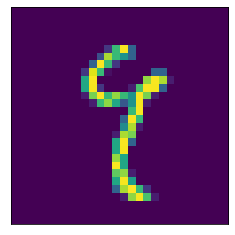

In [48]:
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(X_test[59].reshape((28, 28)))#what number is that?!

In [49]:
y_pred_prob[59]#probabilities of getting each number. It might be 7, 8, or 9 in this case

array([2.62413588e-06, 1.44794428e-02, 3.05286152e-04, 5.89666358e-03,
       9.84044290e-03, 6.18215179e-03, 1.84946395e-05, 5.86707423e-01,
       2.65395576e-01, 1.11171895e-01])

In [50]:
from sklearn.metrics import accuracy_score

accuracy_score(y_predict, y_test)#92% accuracy

0.9187812187812188

# 3. Counting Poissons

The `data/fish.csv` is a data set of camping trips taken by 250 groups of people.

- The campers may or may not have done some fishing during their trip.
- If a group did some fishing, they would have caught zero or mor fish.
- We want to estimate not only how many fish were caught (if there was fishing done by a camping group), but also the probability that the camping group caught any fish at all.

Here's info on the columns:

**FISH_COUNT:** The number of fish that were caught. This will be our dependent variable y.

**LIVE_BAIT:** A binary variable indicating whether live bait was used.

**CAMPER:** Whether the fishing group used a camper van.

**PERSONS:** Total number of people in the fishing group. Note that in some groups, none of them may have fished.

**CHILDREN:** The number of children in the camping group.

Your task is to predict the number of fish caught (FISH_COUNT) by a camping group based on the values of LIVE_BAIT, CAMPER, PERSONS and CHILDREN variables.

Use what we learned on count variables and zero-inflated datasets to achieve the best model you can.

Interpret the models you used to give an analysis of each feature's effect on the predicted fish caught.

**N.B.** Please appreciate the effort I went through to find a fish dataset for a count problem pun.

In [51]:
import pandas as pd
import statsmodels.api as sm
import seaborn as sns

df = pd.read_csv('data/fish.csv')
df

,LIVE_BAIT,CAMPER,PERSONS,CHILDREN,FISH_COUNT
0,0,0,1,0,0
1,1,1,1,0,0
2,1,0,1,0,0
3,1,1,2,1,0
4,1,0,1,0,1
...,...,...,...,...,...
245,1,1,2,0,0
246,1,1,4,3,0
247,1,1,2,1,0
248,1,1,3,2,0


In [52]:
y = df['FISH_COUNT']
x1 = df['LIVE_BAIT']
x2 = df['CAMPER']
x3 = df['PERSONS']
x4 = df['CHILDREN']

summary1 = sm.Poisson(y, sm.add_constant(x1)).fit().summary()
summary2 = sm.Poisson(y, sm.add_constant(x2)).fit().summary()
summary3 = sm.Poisson(y, sm.add_constant(x3)).fit().summary()
summary4 = sm.Poisson(y, sm.add_constant(x4)).fit().summary()

summary1negbin = sm.NegativeBinomial(y, sm.add_constant(x1)).fit().summary()
summary2negbin = sm.NegativeBinomial(y, sm.add_constant(x2)).fit().summary()
summary3negbin = sm.NegativeBinomial(y, sm.add_constant(x3)).fit().summary()
summary4negbin = sm.NegativeBinomial(y, sm.add_constant(x4)).fit().summary()

summary1inflated = sm.ZeroInflatedPoisson(y, sm.add_constant(x1)).fit().summary()
summary2inflated = sm.ZeroInflatedPoisson(y, sm.add_constant(x2)).fit().summary()
summary3inflated = sm.ZeroInflatedPoisson(y, sm.add_constant(x3)).fit().summary()
summary4inflated = sm.ZeroInflatedPoisson(y, sm.add_constant(x4)).fit().summary()

Optimization terminated successfully.
         Current function value: 6.330144
         Iterations 7
Optimization terminated successfully.
         Current function value: 6.222351
         Iterations 6
Optimization terminated successfully.
         Current function value: 5.508158
         Iterations 6
Optimization terminated successfully.
         Current function value: 5.775560
         Iterations 7
Optimization terminated successfully.
         Current function value: 1.834652
         Iterations: 5
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 1.834551
         Iterations: 6
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 1.787778
         Iterations: 13
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 1.777666


In [53]:
summary1, summary1inflated, summary1negbin
#Most people caught at least 2 fish using live bait, as evidenced by the p-value being equal to 0 and the coefficient.

(<class 'statsmodels.iolib.summary.Summary'>
 """
                           Poisson Regression Results                          
 Dep. Variable:             FISH_COUNT   No. Observations:                  250
 Model:                        Poisson   Df Residuals:                      248
 Method:                           MLE   Df Model:                            1
 Date:                Sat, 06 Feb 2021   Pseudo R-squ.:                 0.03956
 Time:                        15:55:22   Log-Likelihood:                -1582.5
 converged:                       True   LL-Null:                       -1647.7
 Covariance Type:            nonrobust   LLR p-value:                 3.419e-30
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 const         -0.5819      0.229     -2.537      0.011      -1.032      -0.132
 LIVE_BAIT      1.8975      0.232      8.175      0.000       1.443   

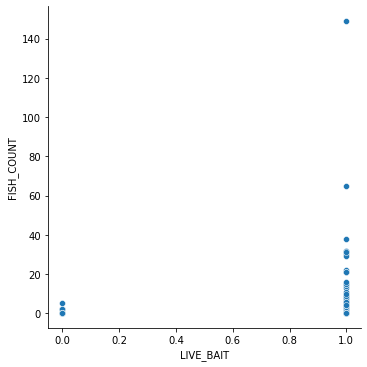

In [54]:
sns.relplot('LIVE_BAIT', 'FISH_COUNT', data=df)

In [55]:
summary2, summary2inflated, summary2negbin
#Most people caught at least 1 fish if they had a camper, as evidenced by the p-value being equal to 0 and the coefficient.

(<class 'statsmodels.iolib.summary.Summary'>
 """
                           Poisson Regression Results                          
 Dep. Variable:             FISH_COUNT   No. Observations:                  250
 Model:                        Poisson   Df Residuals:                      248
 Method:                           MLE   Df Model:                            1
 Date:                Sat, 06 Feb 2021   Pseudo R-squ.:                 0.05591
 Time:                        15:55:22   Log-Likelihood:                -1555.6
 converged:                       True   LL-Null:                       -1647.7
 Covariance Type:            nonrobust   LLR p-value:                 5.705e-42
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 const          0.4215      0.080      5.282      0.000       0.265       0.578
 CAMPER         1.0908      0.089     12.297      0.000       0.917   

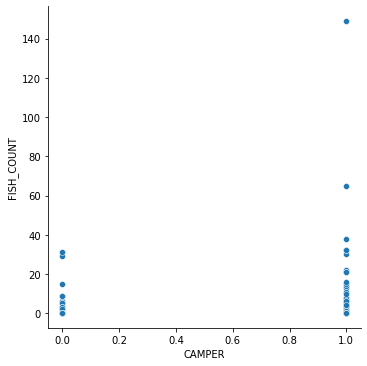

In [56]:
sns.relplot('CAMPER', 'FISH_COUNT', data=df)

In [57]:
summary3, summary3inflated, summary3negbin
#Most people caught at least 1 fish if they weren't alone, as evidenced by the p-value being equal to 0 and the coefficient.

(<class 'statsmodels.iolib.summary.Summary'>
 """
                           Poisson Regression Results                          
 Dep. Variable:             FISH_COUNT   No. Observations:                  250
 Model:                        Poisson   Df Residuals:                      248
 Method:                           MLE   Df Model:                            1
 Date:                Sat, 06 Feb 2021   Pseudo R-squ.:                  0.1643
 Time:                        15:55:22   Log-Likelihood:                -1377.0
 converged:                       True   LL-Null:                       -1647.7
 Covariance Type:            nonrobust   LLR p-value:                9.579e-120
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 const         -1.2840      0.141     -9.096      0.000      -1.561      -1.007
 PERSONS        0.8264      0.040     20.506      0.000       0.747   

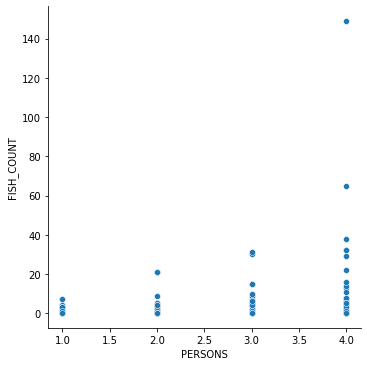

In [58]:
sns.relplot('PERSONS', 'FISH_COUNT', data=df)

In [59]:
summary4, summary4inflated, summary4negbin
#Most people caught fewer fish as the number of children increased, as evidenced by the p-value being equal to 0 and the coefficient.

(<class 'statsmodels.iolib.summary.Summary'>
 """
                           Poisson Regression Results                          
 Dep. Variable:             FISH_COUNT   No. Observations:                  250
 Model:                        Poisson   Df Residuals:                      248
 Method:                           MLE   Df Model:                            1
 Date:                Sat, 06 Feb 2021   Pseudo R-squ.:                  0.1237
 Time:                        15:55:22   Log-Likelihood:                -1443.9
 converged:                       True   LL-Null:                       -1647.7
 Covariance Type:            nonrobust   LLR p-value:                 1.190e-90
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 const          1.6609      0.038     44.164      0.000       1.587       1.735
 CHILDREN      -1.2464      0.080    -15.586      0.000      -1.403   

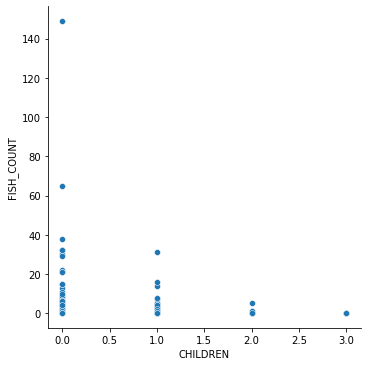

In [60]:
sns.relplot('CHILDREN', 'FISH_COUNT', data=df)

Optimization terminated successfully.
         Current function value: 0.495335
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             FISH_COUNT   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     13.05
Date:                Sat, 06 Feb 2021   Prob (F-statistic):           2.90e-11
Time:                        15:55:27   Log-Likelihood:                -938.12
No. Observations:                 250   AIC:                             1888.
Df Residuals:                     244   BIC:                             1909.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.4807      2.556     -4.100      0.000     -15.516      -5.445
LIVE_BAIT      6.3331      2.468      2.566      0.011       1.471      11.195
CAMPER         6.9381      2.233      3.108      0.002       2.541      11.336
PERSONS        9.5638      2.288      4.180      0.000       5.058      14.070
CHILDREN     -14.1342      3.950     -3.578      0.000     -21.915      -6.353
stage1       -23.8062     10.774     -2.210      0.028     -45.028      -2.584
==============================================================================
Omnibus:                      420.458   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           114163.931
Skew:                           8.715   Prob(JB):                         0.00
Kurtosis:                     106.228   Cond. No.                         57.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

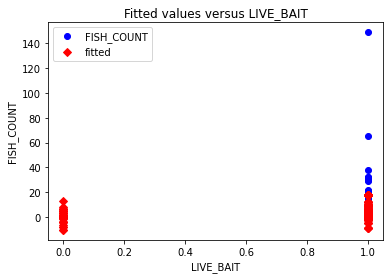

In [61]:
#HURDLE MODEL FOR FUN
x = df[['LIVE_BAIT','CAMPER','PERSONS','CHILDREN']]
y = df['FISH_COUNT']

# Stage 1
est1 = sm.Logit((y > 0).astype(int), sm.add_constant(x)).fit()#astype(int) is necessary because the Logit wants real numbers, not Booleans
# Prep Stage 2
X = pd.DataFrame(sm.add_constant(x))
X['stage1'] = est1.predict(X)
X.columns = ['const', 'LIVE_BAIT', 'CAMPER', 'PERSONS', 'CHILDREN', 'stage1']
# Stage 2
est2 = sm.OLS(y, X).fit()
sm.graphics.plot_fit(est2, 1, vlines=False)
est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             FISH_COUNT   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     14.86
Date:                Sat, 06 Feb 2021   Prob (F-statistic):           6.96e-11
Time:                        15:55:28   Log-Likelihood:                -940.59
No. Observations:                 250   AIC:                             1891.
Df Residuals:                     245   BIC:                             1909.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.1847      2.508     -3.662      0.000     -14.124      -4.245
LIVE_BAIT      2.9480      1.951      1.511      0.132      -0.894       6.790
CAMPER         3.0077      1.360      2.212      0.028       0.329       5.686
PERSONS        4.7587      0.716      6.646      0.000       3.348       6.169
CHILDREN      -5.6503      0.936     -6.034      0.000      -7.495      -3.806
==============================================================================
Omnibus:                      425.798   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           121332.736
Skew:                           8.922   Prob(JB):                         0.00
Kurtosis:                     109.440   Cond. No.                         14.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

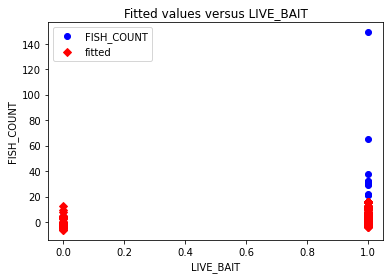

In [62]:
est_lin = sm.OLS(y, X[['const', 'LIVE_BAIT', 'CAMPER', 'PERSONS', 'CHILDREN']]).fit()
sm.graphics.plot_fit(est_lin, 1, vlines=False)
est_lin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             FISH_COUNT   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     15.35
Date:                Sat, 06 Feb 2021   Prob (F-statistic):           6.61e-15
Time:                        15:55:29   Log-Likelihood:                -927.57
No. Observations:                 250   AIC:                             1869.
Df Residuals:                     243   BIC:                             1894.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5088      3.417      0.149      0.882      -6.223       7.240
LIVE_BAIT      7.1208      2.377      2.995      0.003       2.438      11.803
CAMPER         7.0576      2.145      3.290      0.001       2.833      11.283
PERSONS        8.4021      2.212      3.798      0.000       4.045      12.759
CHILDREN     -15.3439      3.804     -4.034      0.000     -22.837      -7.851
stage1       -71.8939     14.672     -4.900      0.000    -100.794     -42.994
stage1_2      47.8456     10.346      4.624      0.000      27.466      68.226
==============================================================================
Omnibus:                      415.272   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           113017.251
Skew:                           8.487   Prob(JB):                         0.00
Kurtosis:                     105.769   Cond. No.                         86.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

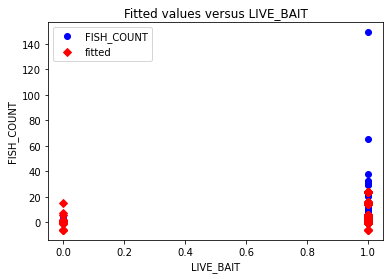

In [63]:
X['stage1_2'] = X.stage1 ** 2

est3 = sm.OLS(y, X).fit()
sm.graphics.plot_fit(est3, 1, vlines=False)
est3.summary()# When all factors are accounted for together, all p-values are significant, but groups caught different quantities of fish. If there were more people, fewer children, a camper, and live_bait, people were catching more fish on average.

# 5. Survival Question

The `data/telco_churn.csv` dataset comes from [here](https://www.kaggle.com/blastchar/telco-customer-churn) and here is the description:

**Context**

"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." [IBM Sample Data Sets]
Content

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents


**5.1 StreamingTV churn**

The `Tenure` column is how long the customer lasted. Make the survival curve for both the group using StreamingTV and the one not using it in the dataset

![](streamingtv.png)


**5.2 Survival Regression**

Use either lifelines or statsmodels to implement a survival regression model predicting tenure. Don't forget to use the churn column as the event column.

In [64]:
import pandas as pd
from lifelines import KaplanMeierFitter

df = pd.read_csv('data/telco_churn.csv')
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


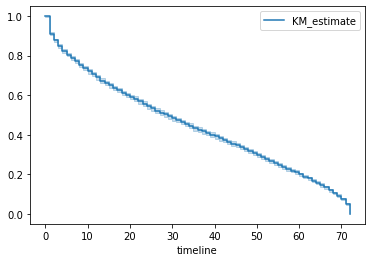

In [65]:
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
kmf = KaplanMeierFitter() 
tenure = df['tenure']     
turnover = df['Churn']

kmf = KaplanMeierFitter()
kmf.fit(tenure)
kmf.plot_survival_function()

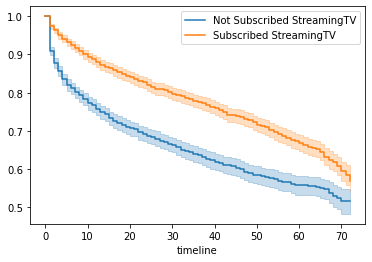

In [66]:
kmf1 = KaplanMeierFitter() 
streaming = df['StreamingTV']
i1 = (streaming == 'No')      
i2 = (streaming == 'Yes')     
kmf1.fit(tenure[i1], turnover[i1], label = 'Not Subscribed StreamingTV')
a1 = kmf1.plot()
kmf1.fit(tenure[i2], turnover[i2], label = 'Subscribed StreamingTV')
kmf1.plot(ax = a1)

In [67]:
#This wasn't fun and I did it the long way

from lifelines import CoxPHFitter

df['gender'] = df['gender'].apply(lambda x: 1 if x == 'Male' else 0 )
df['Partner'] = df['Partner'].apply(lambda x: 1 if x == 'Yes' else 0 )
df['Dependents'] = df['Dependents'].apply(lambda x: 1 if x == 'Yes' else 0 )
df['PhoneService'] = df['PhoneService'].apply(lambda x: 1 if x == 'Yes' else 0 )
df['MultipleLines'] = df['MultipleLines'].apply(lambda x: 1 if x == 'Yes' else 0 )
df['InternetService'] = df['InternetService'].apply(lambda x: 1 if x == 'DSL' else 0 )
df['OnlineSecurity'] = df['OnlineSecurity'].apply(lambda x: 1 if x == 'Yes' else 0 )
df['OnlineBackup'] = df['OnlineBackup'].apply(lambda x: 1 if x == 'Yes' else 0 )
df['DeviceProtection'] = df['DeviceProtection'].apply(lambda x: 1 if x == 'Yes' else 0 )
df['TechSupport'] = df['TechSupport'].apply(lambda x: 1 if x == 'Yes' else 0 )
df['StreamingTV'] = df['StreamingTV'].apply(lambda x: 1 if x == 'Yes' else 0 )
df['StreamingMovies'] = df['StreamingMovies'].apply(lambda x: 1 if x == 'Yes' else 0 )
df['Contract'] = df['Contract'].apply(lambda x: 1 if x == 'One year' else 0 )
df['PaperlessBilling'] = df['PaperlessBilling'].apply(lambda x: 1 if x == 'Yes' else 0 )
df['PaymentMethod'] = df['PaymentMethod'].apply(lambda x: 1 if x == 'Credit card (automatic)' else 0 )
df['MonthlyCharges'] = pd.to_numeric(df['MonthlyCharges'], errors = 'coerce')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors = 'coerce')

df_new = df[['tenure', 'Churn', 'gender', 'Partner', 'Dependents', 'PhoneService',
             'MultipleLines', 'InternetService', 'OnlineSecurity',
             'OnlineBackup', 'DeviceProtection', 'TechSupport',
             'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
             'PaymentMethod', 'MonthlyCharges', 'TotalCharges']]
df_new = df_new.dropna()
df_new.info()

# Using Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(df_new, duration_col = 'tenure', event_col = 'Churn')

cph.print_summary()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tenure            7032 non-null   int64  
 1   Churn             7032 non-null   int64  
 2   gender            7032 non-null   int64  
 3   Partner           7032 non-null   int64  
 4   Dependents        7032 non-null   int64  
 5   PhoneService      7032 non-null   int64  
 6   MultipleLines     7032 non-null   int64  
 7   InternetService   7032 non-null   int64  
 8   OnlineSecurity    7032 non-null   int64  
 9   OnlineBackup      7032 non-null   int64  
 10  DeviceProtection  7032 non-null   int64  
 11  TechSupport       7032 non-null   int64  
 12  StreamingTV       7032 non-null   int64  
 13  StreamingMovies   7032 non-null   int64  
 14  Contract          7032 non-null   int64  
 15  PaperlessBilling  7032 non-null   int64  
 16  PaymentMethod     7032 non-null   int64  


<lifelines.CoxPHFitter: fitted with 7032 total observations, 5163 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 7032
number of events observed = 1869
   partial log-likelihood = -12937.36
         time fit was run = 2021-02-06 20:55:32 UTC

---
                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                
gender            -0.04       0.96       0.05            -0.13             0.05                 0.87                 1.05
Partner           -0.20       0.82       0.05            -0.31            -0.09                 0.74                 0.91
Dependents        -0.17       0.84       0.07            -0.30            -0.04                 0.74                 0.96
PhoneService      -1.22       0.29       0.11            -1.44            -1.01                 0.24                 0.37
MultipleLines     -0.41       0.66       0.05            -0.52            -0.31                 0.60                 0.73
InternetService    1.38       3.96       0.09             1.20             1.55                 3.31                 4.73
OnlineSecurity    -0.86       0.42       0.07            -1.00            -0.72                 0.37                 0.49
OnlineBackup      -0.56       0.57       0.06            -0.68            -0.45                 0.51                 0.64
DeviceProtection  -0.51       0.60       0.06            -0.62            -0.39                 0.54                 0.68
TechSupport       -0.80       0.45       0.07            -0.93            -0.66                 0.39                 0.52
StreamingTV       -0.74       0.48       0.06            -0.86            -0.62                 0.42                 0.54
StreamingMovies   -0.74       0.48       0.06            -0.86            -0.62                 0.42                 0.54
Contract          -0.39       0.68       0.09            -0.56            -0.21                 0.57                 0.81
PaperlessBilling   0.25       1.29       0.06             0.14             0.36                 1.15                 1.44
PaymentMethod     -0.41       0.66       0.07            -0.55            -0.27                 0.58                 0.76
MonthlyCharges     0.11       1.12       0.00             0.11             0.12                 1.11                 1.13
TotalCharges      -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00

                      z      p   -log2(p)
covariate                                
gender            -0.95   0.34       1.54
Partner           -3.61 <0.005      11.65
Dependents        -2.48   0.01       6.25
PhoneService     -11.11 <0.005      92.81
MultipleLines     -7.76 <0.005      46.74
InternetService   15.07 <0.005     168.09
OnlineSecurity   -12.00 <0.005     107.82
OnlineBackup      -9.80 <0.005      72.92
DeviceProtection  -8.80 <0.005      59.39
TechSupport      -11.50 <0.005      99.26
StreamingTV      -11.99 <0.005     107.65
StreamingMovies  -11.96 <0.005     107.07
Contract          -4.42 <0.005      16.60
PaperlessBilling   4.43 <0.005      16.68
PaymentMethod     -5.70 <0.005      26.30
MonthlyCharges    35.55 <0.005     916.88
TotalCharges     -39.80 <0.005        inf
---
Concordance = 0.92
Partial AIC = 25908.71
log-likelihood ratio test = 5431.37 on 17 df
-log2(p) of ll-ratio test = inf